Momentum is useful for optimizing machine learning models because it can improve the speed, stability, and accuracy of gradient descent. 

In [1]:
import torch

num_cpu_cores = torch.get_num_threads()
print("Number of CPU cores:", num_cpu_cores)

Number of CPU cores: 20


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
import time
from torchvision import datasets 

In [3]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12455'

    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()
    
class LungColonCancerDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super(LungColonCancerDataset, self).__init__(root=root_dir, transform=transform)
        
def plot_learning_curves(train_losses, valid_losses, valid_accuracies):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')
    plt.show()

In [4]:
train_losses = []
valid_losses = []
valid_accuracies = []
epoch_times = []  # List to store epoch durations

In [5]:
def train(rank, world_size, batch_size):
    
    setup(rank, world_size)

    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize the images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    data_dir = '/home/hindupur.v/varsha_hpp/dataset/lung_colon_image_set'
    
    # Dataset setup
    train_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'train'), transform=transform)
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of training images (Rank {rank}): {len(train_dataset)}\n")

    validation_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'valid'), transform=transform)
    validation_sampler = DistributedSampler(validation_dataset, num_replicas=world_size, rank=rank)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, sampler=validation_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of validation images (Rank {rank}): {len(validation_dataset)}\n")

    test_dataset = LungColonCancerDataset(root_dir=os.path.join(data_dir, 'test'), transform=transform)
    test_sampler = DistributedSampler(test_dataset, num_replicas=world_size, rank=rank)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=world_size)  # Adjust the number of workers as needed
    print(f"Number of test images (Rank {rank}): {len(test_dataset)}\n")

    # Initialize the model
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    num_ftrs = model.fc.in_features
    num_classes = 5
    model.fc = nn.Linear(num_ftrs, num_classes)  # 5 classes
    
    # Wrap the model with DistributedDataParallel
    ddp_model = nn.parallel.DistributedDataParallel(model)
    print(f"[Rank {rank}] Model initialized and wrapped in DDP.\n")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.001, momentum=0.9)
    
    print(f"[Rank {rank}] Optimizer and loss function are set up.\n")

    num_epochs = 10
    
    start_time = time.time()  # Start timing
    print("start_time", start_time)

    for epoch in range(num_epochs):
        ddp_model.train() 
        epoch_start_time = time.time()  # Start time for the epoch
        running_loss = 0.0
        epoch_train_losses = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = ddp_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_idx % 10 == 0:  # Log every 10 batches
                print(f"[Rank {rank}] Epoch {epoch+1} Batch {batch_idx+1}: Loss {loss.item()}\n")

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}\n')
        
        epoch_duration = time.time() - epoch_start_time  # Calculate duration of the epoch
        epoch_times.append(epoch_duration)  # Append epoch duration to the list
        print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds\n")

        ddp_model.eval()  # Setting model to evaluate mode
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = ddp_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data)

        epoch_val_loss = val_loss / len(validation_loader)
        epoch_accuracy = correct.double() / len(validation_dataset)

        valid_losses.append(epoch_val_loss)
        valid_accuracies.append(epoch_accuracy)

        print(f'[Rank {rank}] Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_accuracy:.4f}\n')

        
    # Plot learning curves
    plot_learning_curves(train_losses, valid_losses, valid_accuracies)
    
    cleanup()
    
    end_time = time.time()  # End timing
    print("total end_time", end_time)
    
    duration = end_time - start_time
    print(f"Rank {rank}: Training duration: {duration:.2f} seconds")
    
    # saving the model for later use without disturbing the rest of the code
    torch.save(model.state_dict(), 'lung_colon_cancer_model_on_20_CPU.pth')

    return ddp_model, train_losses, valid_losses, valid_accuracies, epoch_times

Number of training images (Rank 5): 20000
Number of training images (Rank 1): 20000


Number of training images (Rank 12): 20000
Number of training images (Rank 0): 20000


Number of validation images (Rank 1): 2500

Number of training images (Rank 3): 20000
Number of training images (Rank 4): 20000
Number of validation images (Rank 12): 2500
Number of training images (Rank 8): 20000
Number of validation images (Rank 5): 2500





Number of training images (Rank 6): 20000
Number of training images (Rank 14): 20000
Number of training images (Rank 9): 20000

Number of training images (Rank 19): 20000

Number of test images (Rank 1): 2500
Number of training images (Rank 16): 20000


Number of training images (Rank 2): 20000


Number of training images (Rank 11): 20000
Number of training images (Rank 13): 20000
Number of training images (Rank 17): 20000
Number of validation images (Rank 4): 2500
Number of training images (Rank 10): 20000

Number of validation images (Rank 8): 2500
Number o

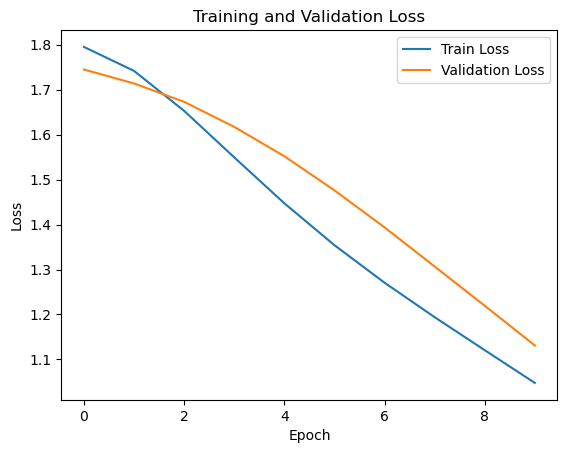

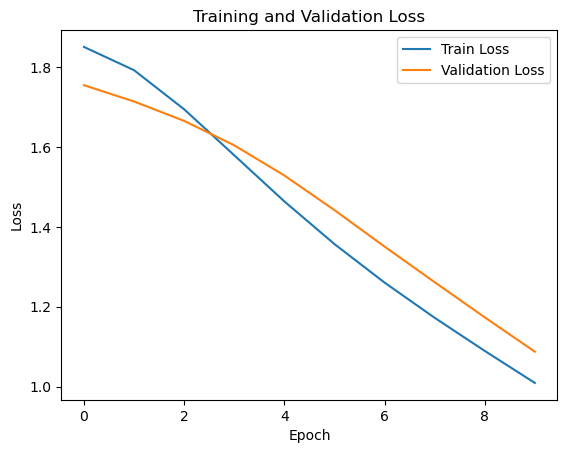

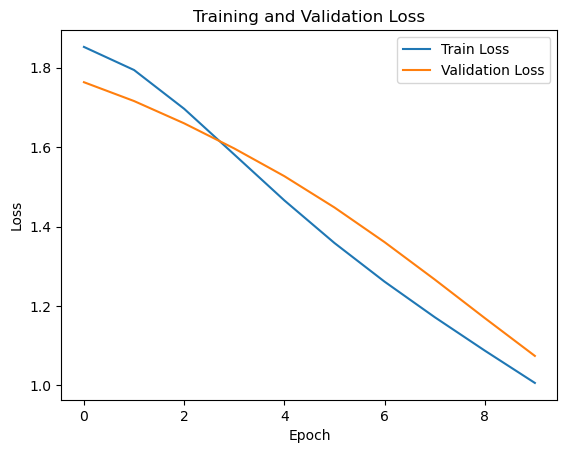

[Rank 13] Epoch 10/10, Val Loss: 1.1583, Accuracy: 0.0332
[Rank 3] Epoch 10/10, Val Loss: 1.0662, Accuracy: 0.0320



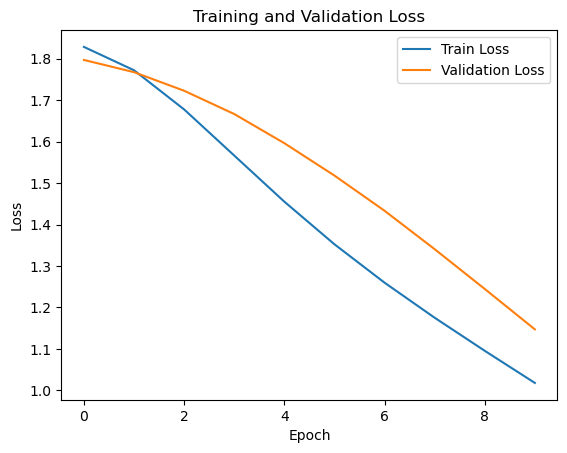

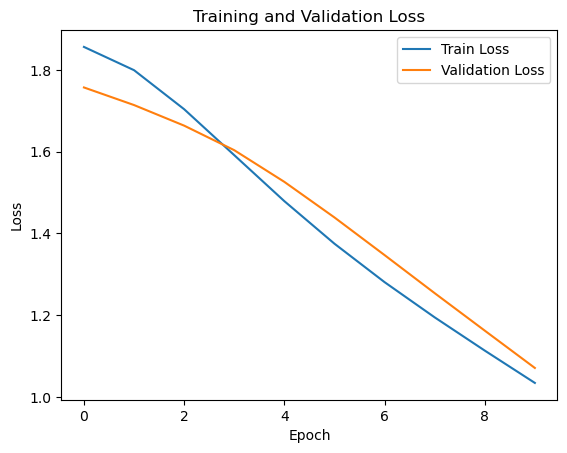

[Rank 2] Epoch 10/10, Val Loss: 1.1197, Accuracy: 0.0308
[Rank 0] Epoch 10/10, Val Loss: 1.0906, Accuracy: 0.0296


[Rank 16] Epoch 10/10, Val Loss: 1.0963, Accuracy: 0.0308


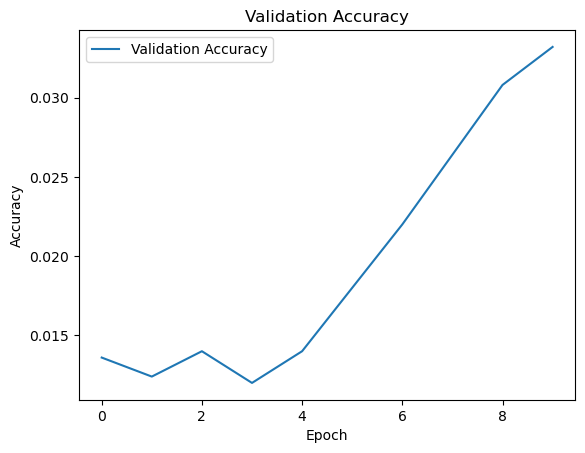


total end_time

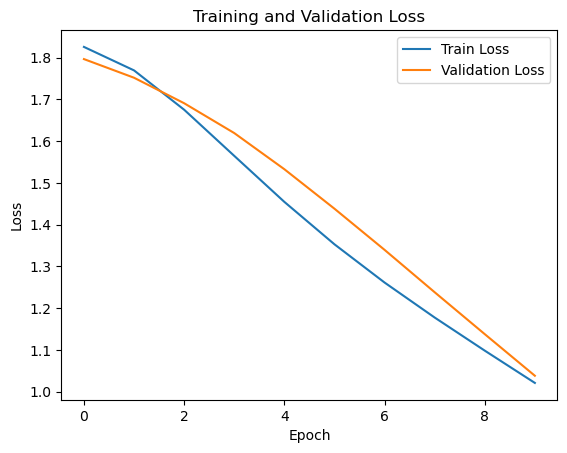

 1713054451.1178813
Rank 4: Training duration: 1645.13 seconds

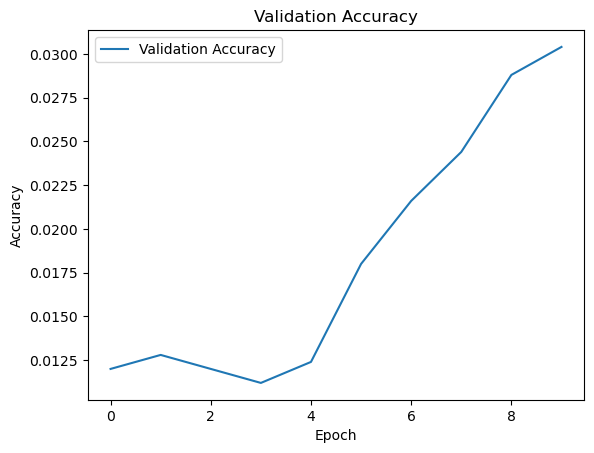

[Rank 6] Epoch 10/10, Val Loss: 1.0560, Accuracy: 0.0328
total end_time


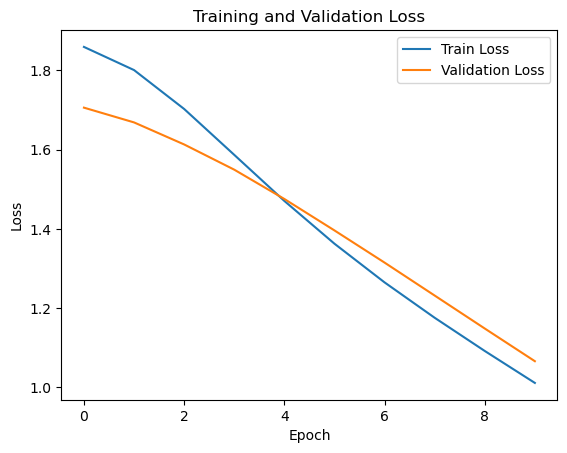

 
1713054451.2515397
[Rank 19] Epoch 10/10, Val Loss: 1.1217, Accuracy: 0.0320
[Rank 17] Epoch 10/10, Val Loss: 1.1261, Accuracy: 0.0320

Rank 15: Training duration: 1643.81 seconds

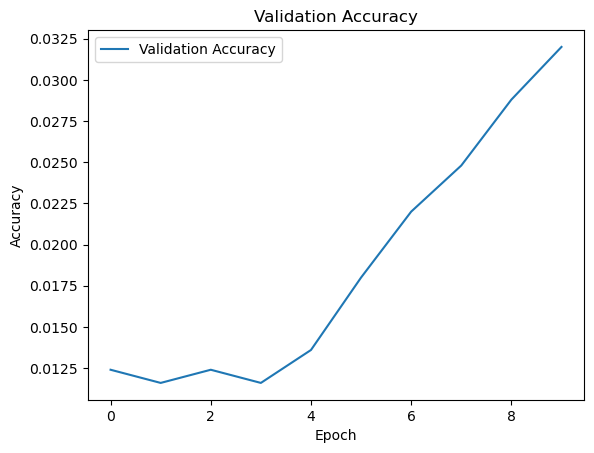



total end_time

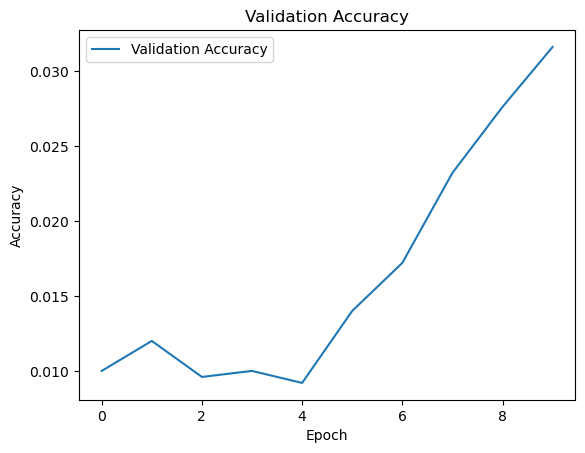

total end_time 1713054451.324293 1713054451.379402

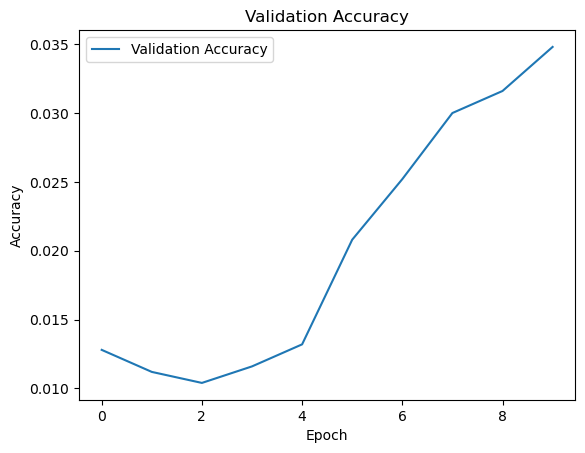

total end_time

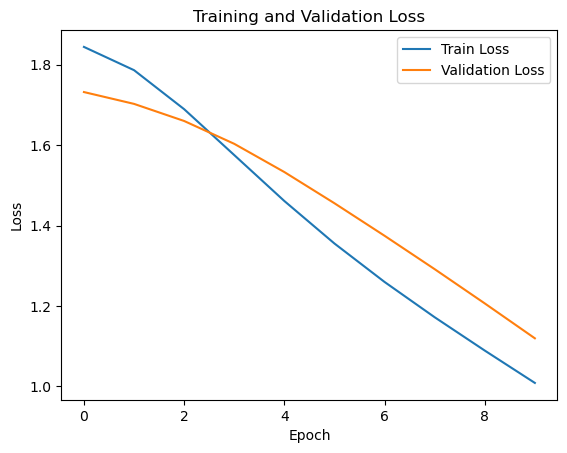

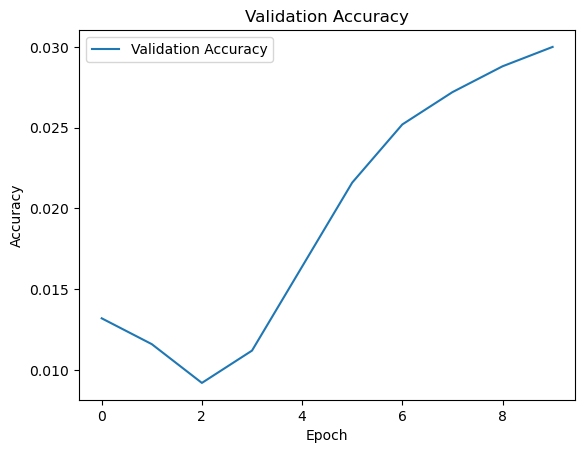

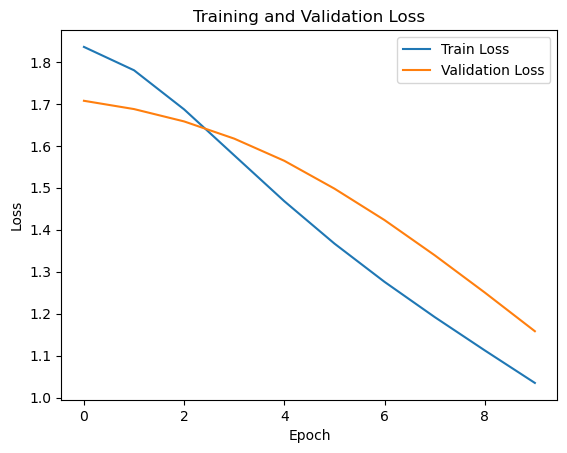

total end_time 

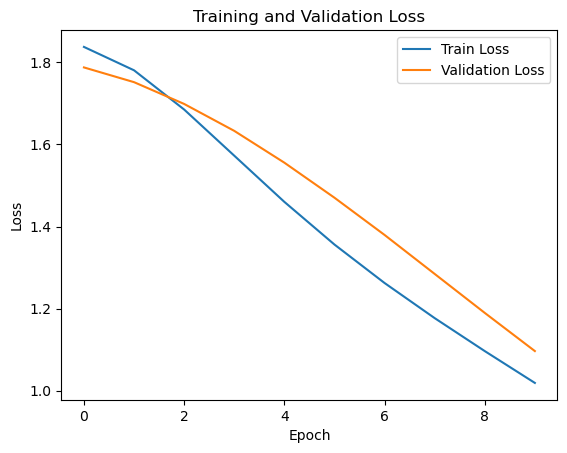


 Rank 12: Training duration: 1644.54 seconds
Rank 7: Training duration: 1644.83 seconds
1713054451.415584
1713054451.4448817

Rank 9: Training duration: 1645.44 secondsRank 8: Training duration: 1645.96 seconds



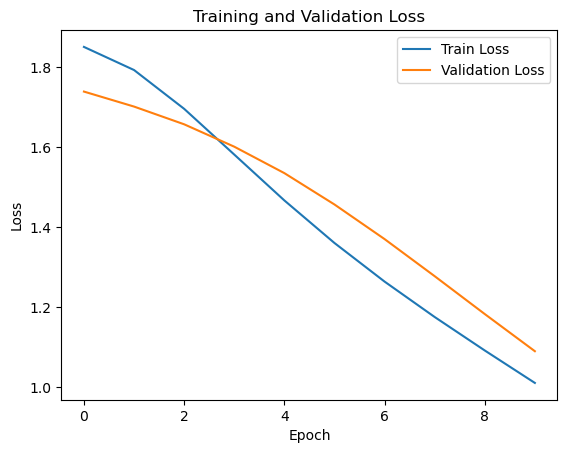

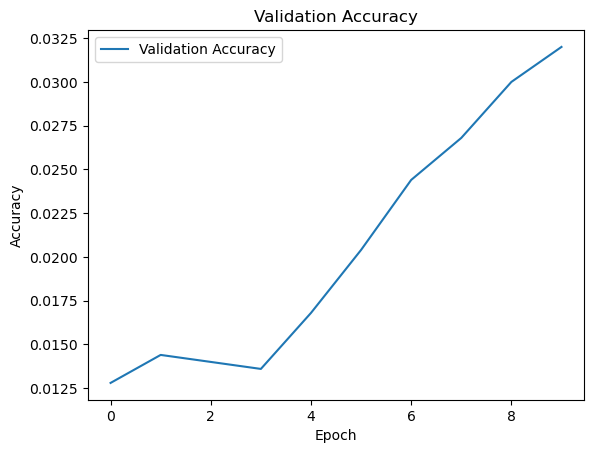

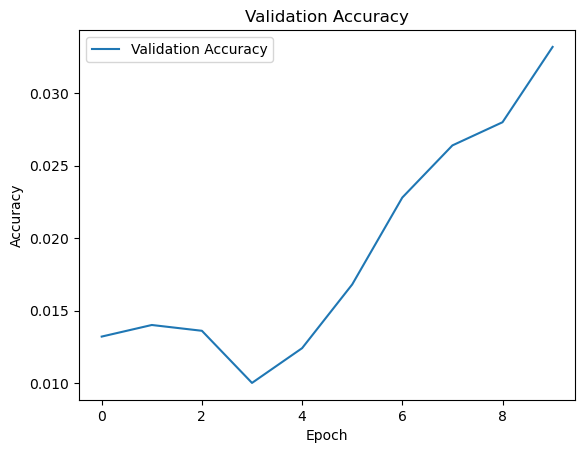

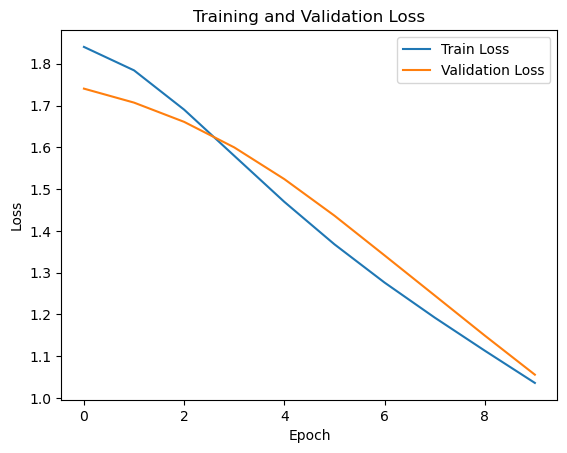

total end_timetotal end_time[Rank 14] Epoch 10/10, Val Loss: 1.1186, Accuracy: 0.0312
 
 

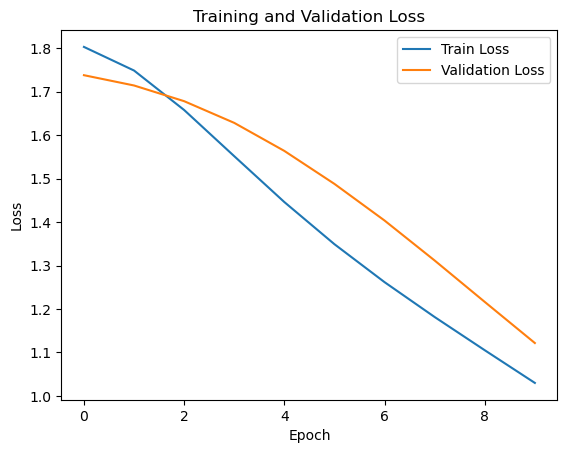

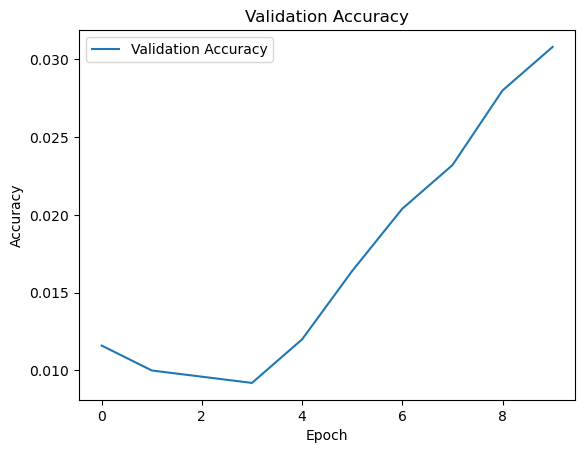

1713054451.6203284total end_time
 Rank 3: Training duration: 1644.73 seconds

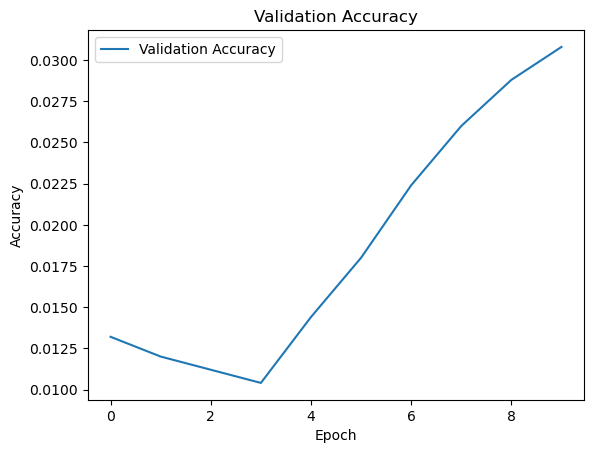

1713054451.6656811total end_time
 1713054451.680968Rank 16: Training duration: 1646.43 seconds
Rank 2: Training duration: 1645.75 seconds
[Rank 10] Epoch 10/10, Val Loss: 1.0735, Accuracy: 0.0336

1713054451.6143677



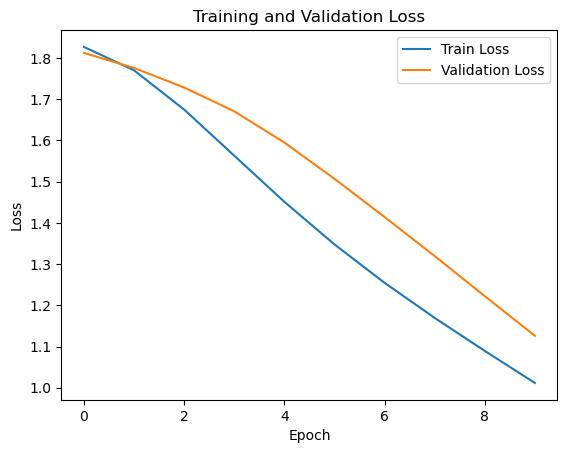

Rank 13: Training duration: 1643.84 seconds



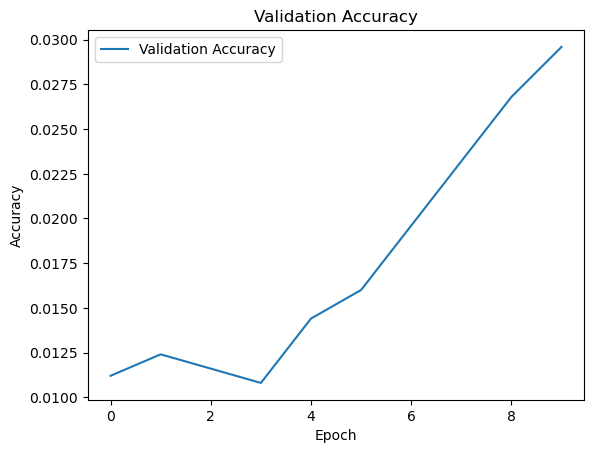

total end_time 1713054451.7970212
Rank 0: Training duration: 1645.92 seconds


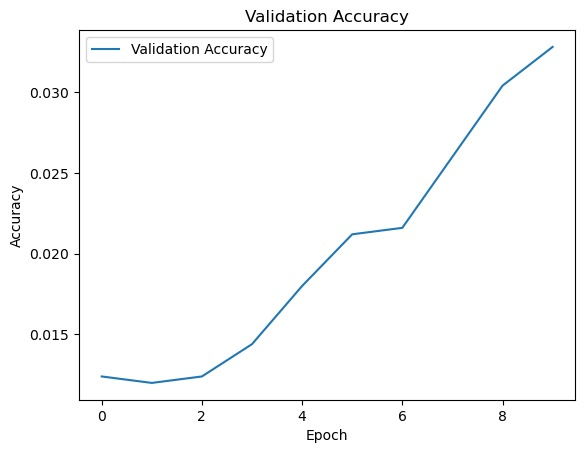

[Rank 18] Epoch 10/10, Val Loss: 1.0619, Accuracy: 0.0340
[Rank 11] Epoch 10/10, Val Loss: 1.1044, Accuracy: 0.0332
total end_time
 
1713054451.8395534


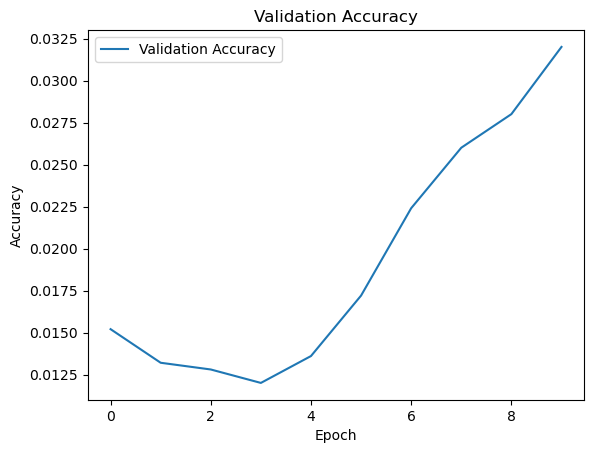

Rank 6: Training duration: 1645.88 seconds

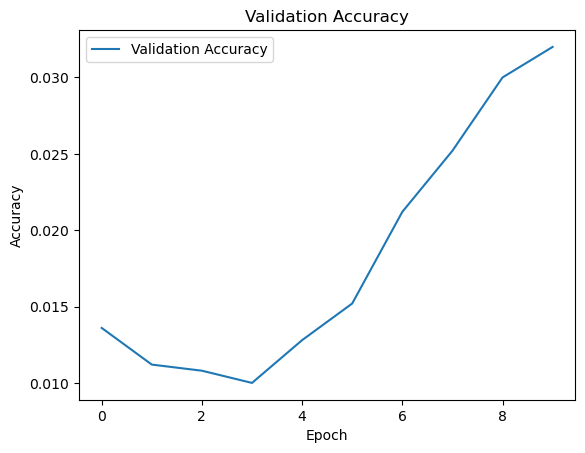


total end_timetotal end_time 1713054451.899711 
1713054451.8985183Rank 19: Training duration: 1644.09 seconds

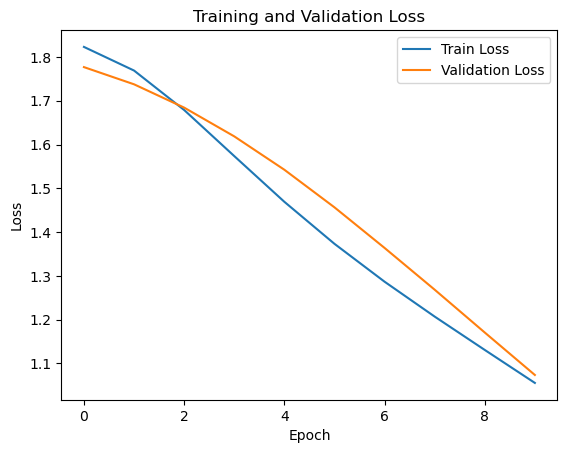


Rank 17: Training duration: 1644.91 seconds



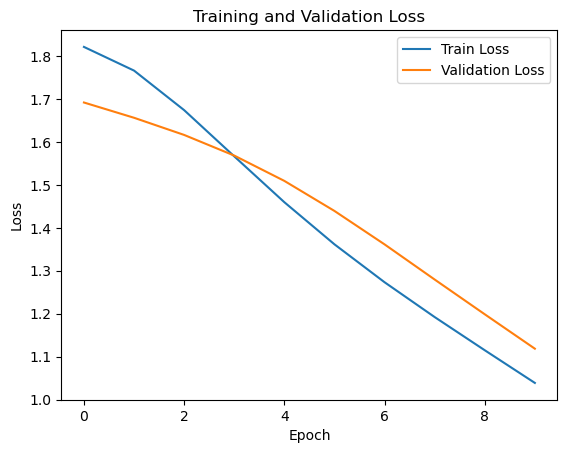

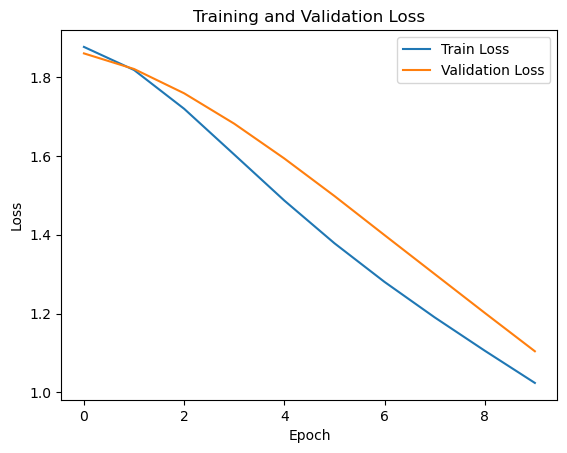

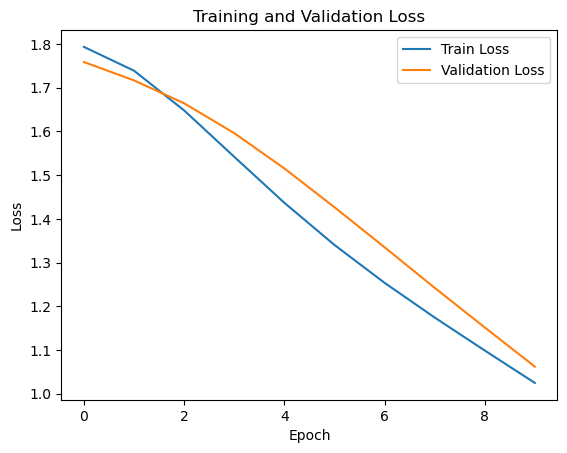

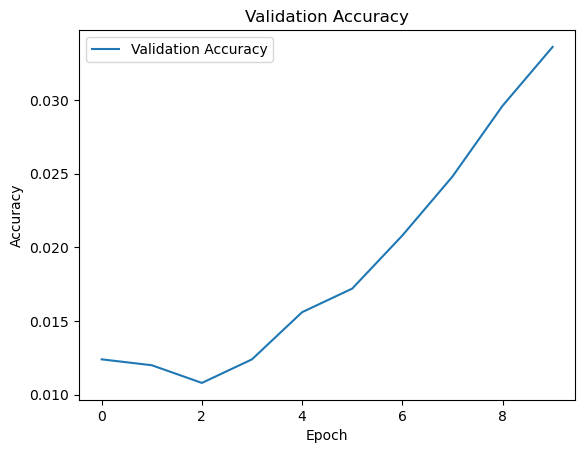

total end_time 1713054452.1033683
Rank 10: Training duration: 1646.18 seconds
[Rank 1] Epoch 10/10, Val Loss: 1.0685, Accuracy: 0.0316



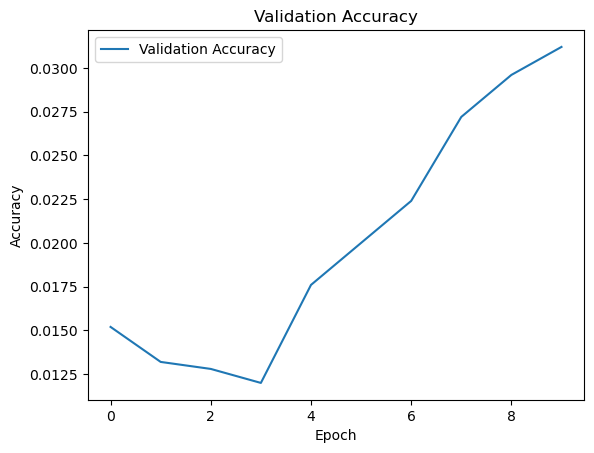

total end_time 1713054452.1369972
Rank 14: Training duration: 1646.14 seconds


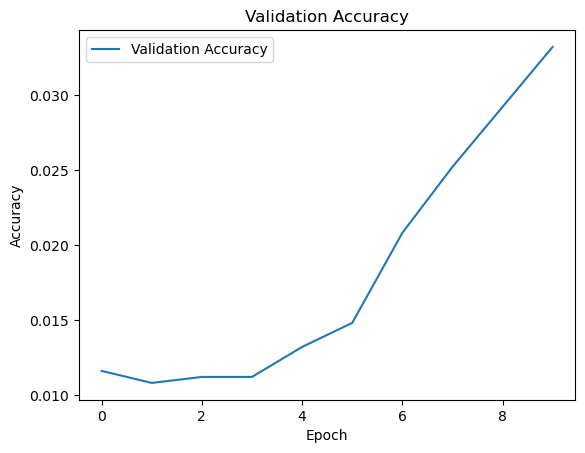

total end_time 1713054452.181195
Rank 11: Training duration: 1645.30 seconds


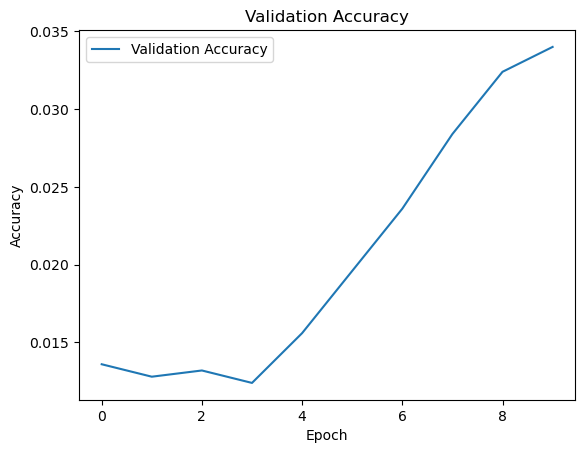

total end_time 1713054452.1910846
Rank 18: Training duration: 1645.53 seconds
[Rank 5] Epoch 10/10, Val Loss: 1.0886, Accuracy: 0.0316



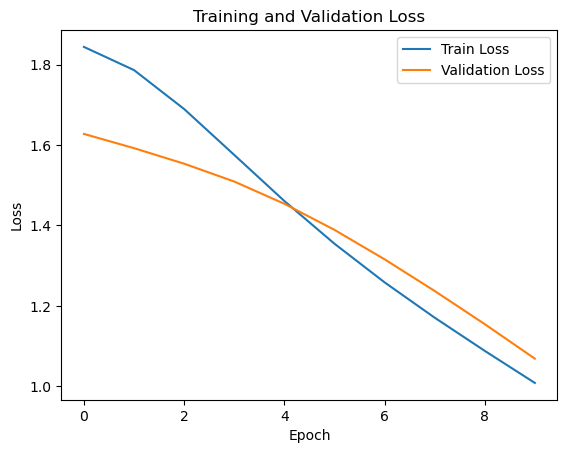

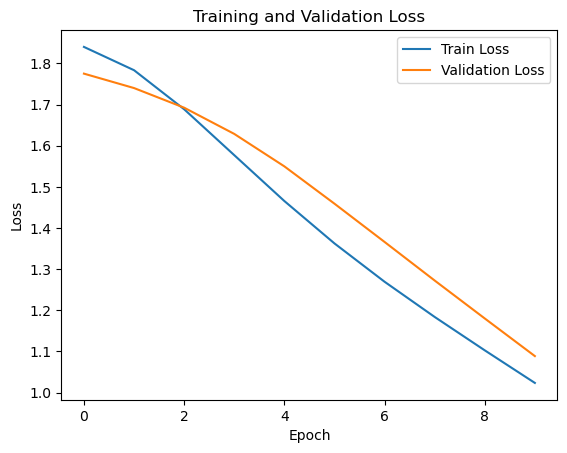

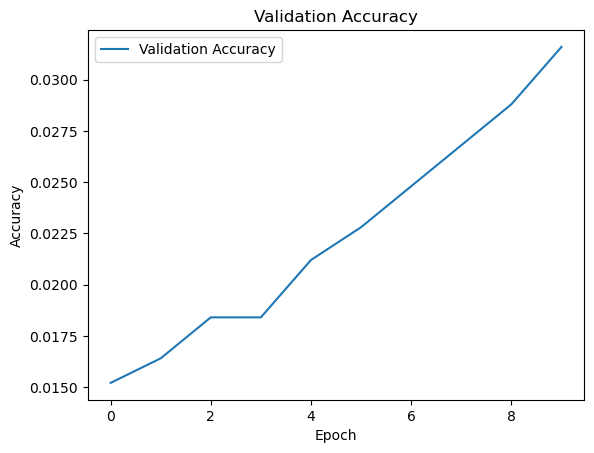

total end_time 1713054452.4748752
Rank 1: Training duration: 1645.68 seconds


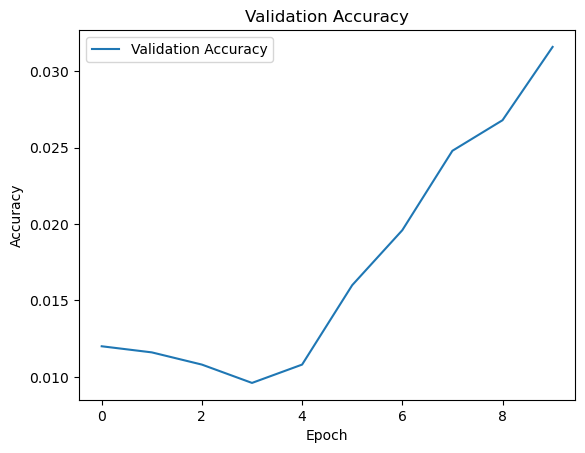

total end_time 1713054452.551219
Rank 5: Training duration: 1646.26 seconds


In [6]:
if __name__ == '__main__':
    world_size = 20
    batch_size = 5000
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=train, args=(rank, world_size, batch_size))
        p.start() 
        processes.append(p)
    for p in processes:
        p.join()

Conclusion:

The average epoch duration for each epoch separately is as follows:

Epoch 1: 146.85 seconds
Epoch 2: 149.10 seconds
Epoch 3: 146.94 seconds
Epoch 4: 146.94 seconds
Epoch 5: 147.57 seconds
Epoch 6: 148.04 seconds
Epoch 7: 146.53 seconds
Epoch 8: 146.51 seconds
Epoch 9: 147.69 seconds
Epoch 10: 147.27 seconds

### The average epoch duration combining all epochs is approximately 147.30 seconds.